In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path, listdir
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# https://drive.google.com/drive/folders/1bynkOIXCurhJ9_Y5Q14KWX5yDyCRkKfN

import zipfile
with zipfile.ZipFile('/content/drive/My Drive/Copy of data.zip','r') as f:
  # extract the files in root and not in content folder
  f.extractall('/')
  

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>


# Task 1: Preprocessing


## 1. Get all the file name and corresponding json files

In [ ]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files

    # https://stackoverflow.com/a/36898903/10219869
    image = []
    path = root_dir+'images/'
    for i, j, k in os.walk(path):
      for m in k:
        image.append(os.path.join(i, m))
    
    json = []
    path = root_dir+'mask/'
    for i, j, k in os.walk(path):
      for m in k:
        json.append(os.path.join(i, m))

    data_df = pd.DataFrame()
    data_df['image'] = sorted(image)
    data_df['json'] = sorted(json)
  
    return data_df

In [ ]:
 # If you observe the dataframe, we can consider each row as single data point, 
 # where first feature is image and the second feature is corresponding json file

root_dir = '/data/'

data_df = return_file_names_df(root_dir)
print(data_df.shape)
data_df.head()

(4008, 2)


image                                           json
0  /data/images/201/frame0029_leftImg8bit.jpg  /data/mask/201/frame0029_gtFine_polygons.json
1  /data/images/201/frame0299_leftImg8bit.jpg  /data/mask/201/frame0299_gtFine_polygons.json
2  /data/images/201/frame0779_leftImg8bit.jpg  /data/mask/201/frame0779_gtFine_polygons.json
3  /data/images/201/frame1019_leftImg8bit.jpg  /data/mask/201/frame1019_gtFine_polygons.json
4  /data/images/201/frame1469_leftImg8bit.jpg  /data/mask/201/frame1469_gtFine_polygons.json

## 2. Structure of sample Json file


<img src='https://i.imgur.com/EfR5KmI.png' >

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

In [ ]:
new_label_clr = {'road': 10, 'parking / drivable fallback': 20,'sidewalk': 30,'non-drivable fallback / rail track': 40,\
                        'person / animal': 50, 'rider': 60, 'motorcycle / bicycle': 70, 'autorickshaw / car': 80, 
             'truck / bus / vehicle fallback / trailer / caravan':90,\
                        'curb / wall':100, 'fence / guard rail':110, 'billboard / traffic sign / traffic light':120, 
             'pole / polegroup / obs-str-bar-fallback':130,'vegetation':150, 'sky / fallback background':160,'unlabeled / out of roi':0,
              'ego vehicle':170, 'ground':180,'rectification border':190, 'train':200, 'building / bridge / tunnel':140, }

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
len(set(label_clr))

40

<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look 
differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 2. Extracting the polygons from the json files

### Example polygon

[(18.0, 6.0), (15.363961030678928, 10.242640687119284), (9.0, 12.0), (2.636038969321073, 10.242640687119284), (0.0, 6.000000000000002), (2.6360389693210706, 1.7573593128807152), (8.999999999999998, 0.0), (15.363961030678928, 1.757359312880714)]
8 

(28, 28, 3) 

[[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0

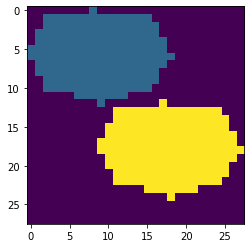

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath 

# polygon sides
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

print(x1)
print(len(x1),'\n')

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value , fill value is color code, and no float is allowed
# writing the first polygon
img1.polygon(x1, fill = 10)
# writing the second polygon
img1.polygon(x2, fill = 30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])

print(img.shape,'\n')
print(img[:,:,0]//10)

im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    a = pd.read_json(file)
    b = []
    # it will process all the objects in that file and returns
    for i in a['objects']:
      b.append(pd.json_normalize(i))

    b = pd.concat(b)
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    label = list(b['label'])
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    v = list(b['polygon'])

    vertexlist = []
    for i in v:
      j = []
      for k in i:
        j.append(tuple(k))
      vertexlist.append(j)    

    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    w = a['imgWidth'][0]
    # height of the image
    h = a['imgHeight'][0]

    return w, h, label, vertexlist

(1080, 1920, 3)

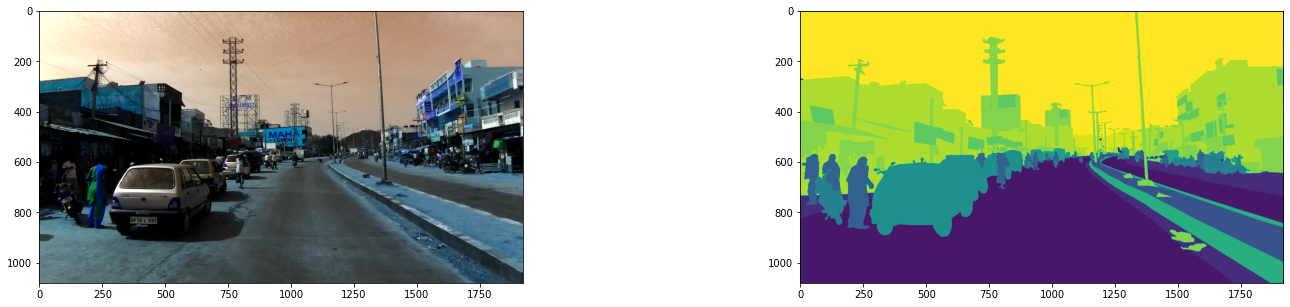

In [ ]:

w, h, label, vertexlist = get_poly(data_df['json'].iloc[0])
img = Image.new("RGB", (w, h))        # create new canvas
img1 = ImageDraw.Draw(img)

for num in range(len(label)):
  if len(vertexlist[num]) > 1:        # vertexlist is 277 and labels also 277 so if some are less than 1 and skip them
      img1.polygon(vertexlist[num], fill = label_clr[label[num]])
  else:
      pass

img = np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
im = Image.fromarray(img[:,:,0] )
a = cv2.imread(data_df['image'].iloc[0])
plt.figure(figsize=(25, 5))
plt.subplot(121)
plt.imshow(a)
plt.subplot(122)
plt.imshow(im , )
# print(img[:,:,0]//10)
im.save('/content/a.png', )
img.shape

In [ ]:
# Colors Dictionary of tuples

color_label_clr = {'road': (128, 64, 128), 'parking': (250, 170, 160), 'drivable fallback': (229, 23, 142),'sidewalk': (244, 35, 232),
             'non-drivable fallback': (156, 60, 200),'rail track' :(192, 192, 192), 'person': (220, 20, 60), 'animal': (199, 151, 187), 
             'rider': (255, 0, 0), 'motorcycle': (0, 0, 230), 'bicycle': (119, 11, 32), 'autorickshaw': (99, 250, 80), 'car': (0, 0, 142), 
             'truck': (0, 0, 70), 'bus': (0, 60, 100), 'vehicle fallback': (82, 92, 214), 'trailer': (50, 150, 250), 
             'caravan': (0, 0, 90), 'curb': (196, 209, 152), 'wall': (102, 102, 156), 'fence': (190, 153, 153),'guard rail': (180, 165, 180), 
             'billboard': (37, 58, 77),'traffic sign': (220, 220, 0), 'traffic light': (250, 170, 30), 'pole': (153, 153, 153), 
             'polegroup': (153, 153, 153), 'obs-str-bar-fallback': (11, 35, 88),'building': (70, 70, 70), 'bridge': (150, 100, 100),
             'tunnel': (150, 120, 90), 'vegetation': (107, 142, 35), 'sky': (70, 130, 180), 'fallback background': (225, 130, 123),
             'unlabeled': (0, 0, 0),  'out of roi': (0, 0, 0), 'ego vehicle': (0, 0, 0), 'ground':(244, 164, 96) ,
             'rectification border': (0, 0, 0),    'train':  (35, 105, 70)}

(1080, 1920, 3)

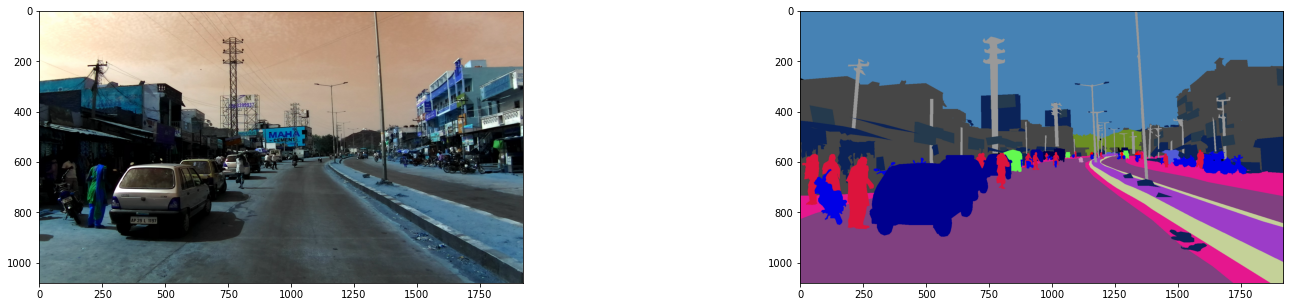

In [ ]:

w, h, label, vertexlist = get_poly(data_df['json'].iloc[0])
img = Image.new("RGB", (w, h))        # create new canvas
img1 = ImageDraw.Draw(img)

for num in range(len(label)):
  if len(vertexlist[num]) > 1:        # vertexlist is 277 and labels also 277 so if some are less than 1 and skip them
      img1.polygon(vertexlist[num], fill = color_label_clr[label[num]])
  else:
      pass

img = np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
im = Image.fromarray(img[:,:,:] )
a = cv2.imread(data_df['image'].iloc[0])
plt.figure(figsize=(25, 5))
plt.subplot(121)
plt.imshow(a)
plt.subplot(122)
plt.imshow(im , )
# print(img[:,:,0]//10)
im.save('/content/a.png', )
img.shape

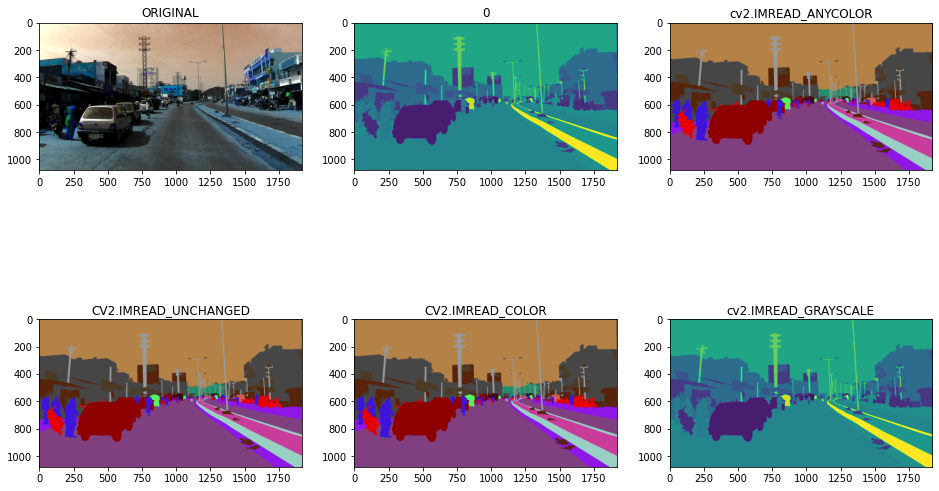

In [ ]:


f, ax = plt.subplots(2,3, figsize = (16, 10))

ax[0,0].imshow(cv2.imread(data_df['image'].iloc[0]))
ax[0,0].title.set_text('ORIGINAL')
ax[0,1].imshow(cv2.imread('/content/a.png', 0))
ax[0,1].title.set_text('0')
ax[0,2].imshow(cv2.imread('/content/a.png', cv2.IMREAD_ANYCOLOR))
ax[0,2].title.set_text('cv2.IMREAD_ANYCOLOR')
ax[1,0].imshow(cv2.imread('/content/a.png', cv2.IMREAD_UNCHANGED))
ax[1,0].title.set_text('CV2.IMREAD_UNCHANGED')
ax[1,1].imshow(cv2.imread('/content/a.png', cv2.IMREAD_COLOR))
ax[1,1].title.set_text('CV2.IMREAD_COLOR')
ax[1,2].imshow(cv2.imread('/content/a.png', cv2.IMREAD_GRAYSCALE))
ax[1,2].title.set_text('cv2.IMREAD_GRAYSCALE')
plt.show()

In [ ]:
from tqdm import tqdm_notebook

def compute_masks(data_df):
    # after you have computed the vertexlist, plot that polygone in image like this

    # we create these paths to save our png files to mask folder
    #https://www.geeksforgeeks.org/python-os-mkdir-method/
    # path1 = os.path.join('/data/' ,'output')
    # os.mkdir(path1)
    mask = []
    for i in tqdm_notebook(list(data_df['json'])):

      first = i[11:14]                                                  # number to place for saved image path
      path2 = os.path.join('/data/output/', str(first) + '/')
      os.makedirs(path2, exist_ok = True)   # creating new dir and path to save images and exist_ok means in for loop no error throws

      w, h, label, vertexlist = get_poly(i) # collect 4 elements

      img = Image.new("RGB", (w, h))        # create new canvas
      img1 = ImageDraw.Draw(img)

      for num in range(len(label)):
        if len(vertexlist[num]) > 1:        # vertexlist is 277 and labels also 277 so if some are less than 1 and skip them
          img1.polygon(vertexlist[num], fill = label_clr[label[num]])
        else:
          pass

      img = np.array(img)
      # note that the filling of the values happens at the channel 1, so we are considering only the first channel here

      im = Image.fromarray(img[:,:,0])
      # after drawing all the polygons that we collected from json file, 
      # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png
    
      op = '/data/output//.png'
      index1 = op.find('/.')
      op1 = op[:index1] + first + op[index1:]
      index2 = op1.find('.p')
      op2 = op1[:index2] + i[15:-5] + op1[index2:]
      
      im.save(op2)
      mask.append(op2)
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    data_df['mask'] = mask
    return  data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


image  ...                                            mask
0  /data/images/201/frame0029_leftImg8bit.jpg  ...  /data/output/201/frame0029_gtFine_polygons.png
1  /data/images/201/frame0299_leftImg8bit.jpg  ...  /data/output/201/frame0299_gtFine_polygons.png
2  /data/images/201/frame0779_leftImg8bit.jpg  ...  /data/output/201/frame0779_gtFine_polygons.png
3  /data/images/201/frame1019_leftImg8bit.jpg  ...  /data/output/201/frame1019_gtFine_polygons.png
4  /data/images/201/frame1469_leftImg8bit.jpg  ...  /data/output/201/frame1469_gtFine_polygons.png

[5 rows x 3 columns]

True
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


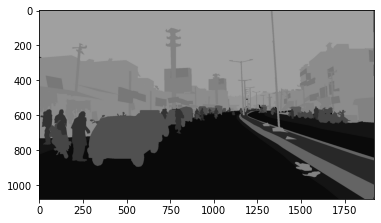

In [ ]:

def grader():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('/data/output/201/frame0029_gtFine_polygons.png')   #  
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    data_df.to_csv('preprocessed_data.csv', index=False)
grader()

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the  same 
with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same unet

* The number of channels in the output will depend on the number of classes in your data, 
since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map, 
note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, 
you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

In [ ]:
pip install segmentation-models==1.0.1

In [ ]:
# !pip install imgaug
# ! pip install --upgrade keras

In [ ]:
import tensorflow as tf
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

from tensorflow.keras import layers
# https://stackoverflow.com/a/59239355/10219869
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, LSTM, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model
import random as rn
# https://stackoverflow.com/a/59019134/10219869
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


Using TensorFlow backend.


In [ ]:
from sklearn.model_selection import train_test_split
X_test, X_train = train_test_split(data_df[['image', 'mask']], test_size=0.90, random_state=42)

In [ ]:
# this is combined of x (image) and y (mask) labels.  
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (3608, 2)
Shape of X_test: (400, 2)


In [ ]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset 40
model = None
model = Unet( backbone_name= 'resnet34', encoder_weights='imagenet', classes= len(new_label_clr.keys()), 
             activation='softmax', input_shape=(None, None,3))

Segmentation Models: using `keras` framework.
85524480/85521592 [==============================] - 8s 0us/step


In [ ]:
"""for layer in model.layers:
  if layer.name != 'decoder_stage0_upsampling':
    layer.trainable = False
  else:
    break
"""
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_1[0][0]           
____________________________________________________________________________________________

In [ ]:
# import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:

    
def normalize_image(mask):
    mask = mask/255
    return mask

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    # CLASSES = list(label_clr.values())
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, image_dir, mask_dir):
        
        # the paths of images
        self.images_fps = image_dir
        # the paths of segmentation images
        self.masks_fps = mask_dir
        # giving labels for each class
        self.class_values = CLASSES
            
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], )
        image = cv2.resize(image, (512, 512))
        mask  = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask, (512, 512))
        image_mask = mask
        # instead of image_mask -> we do not normalize normalise(mask)

        
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('int')
   
        """a = np.random.uniform()
        if a<0.2:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = aug5.augment_image(image_mask)
        else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)
        """    
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:

# Dataset for train images
CLASSES = list(new_label_clr.values())
train_dataset = Dataset(list(X_train['image']),list(X_train['mask']))
test_dataset  = Dataset(list(X_test['image']),list(X_test['mask']))



In [ ]:
def visualize(images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image,  vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()

road


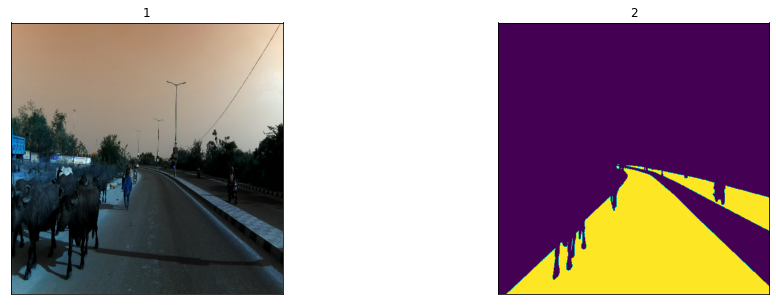

parking / drivable fallback


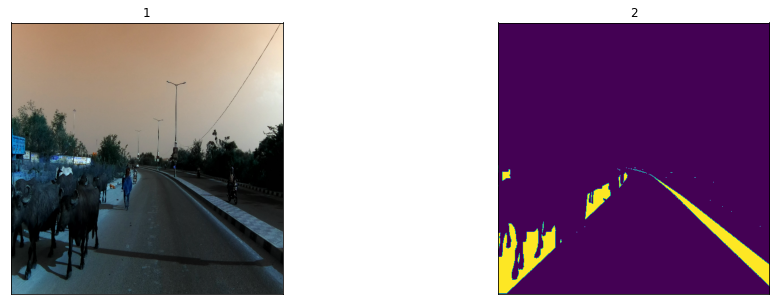

sidewalk


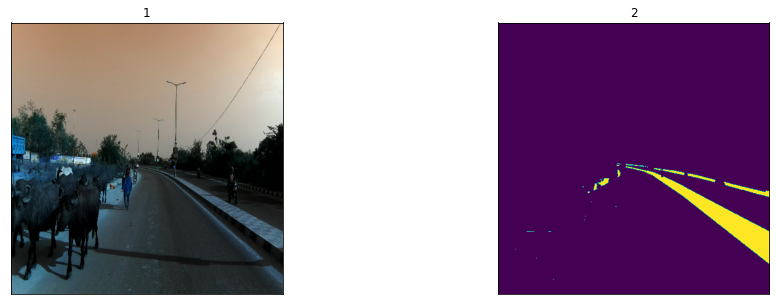

non-drivable fallback / rail track


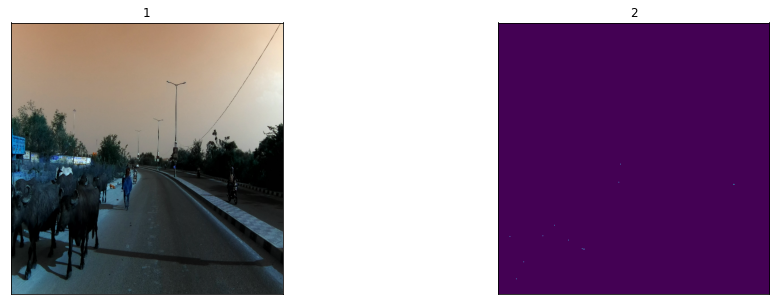

person / animal


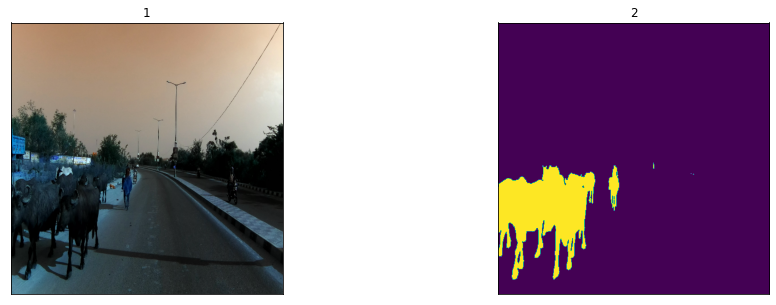

rider


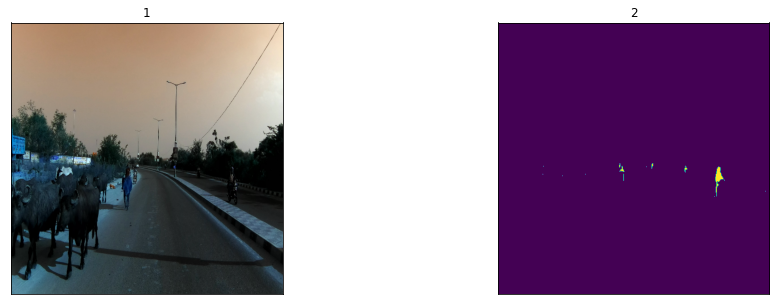

motorcycle / bicycle


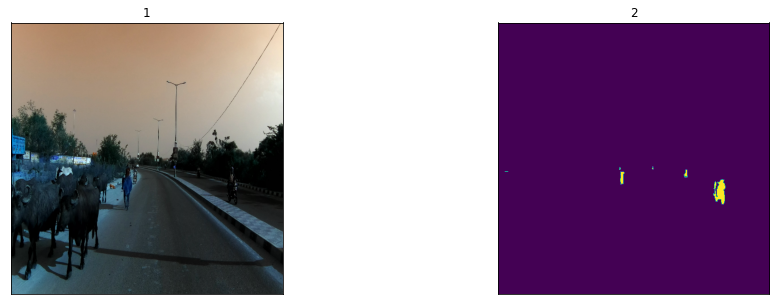

autorickshaw / car


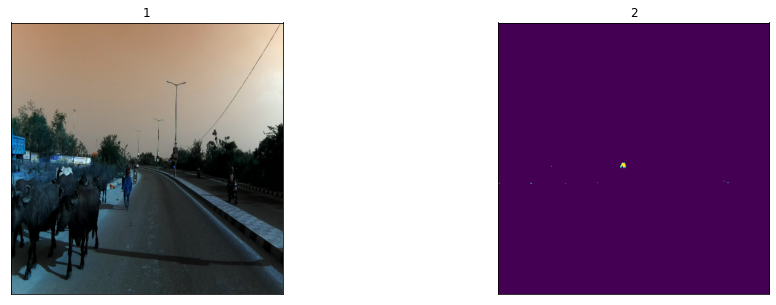

truck / bus / vehicle fallback / trailer / caravan


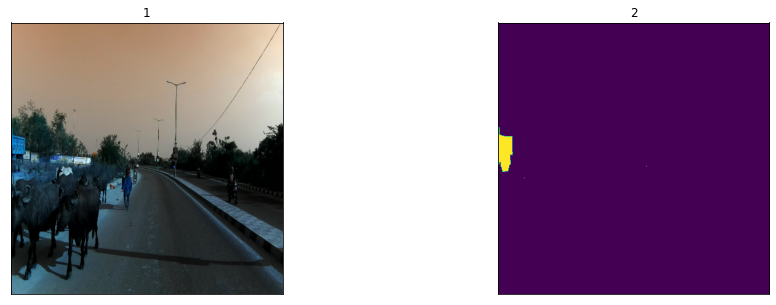

curb / wall


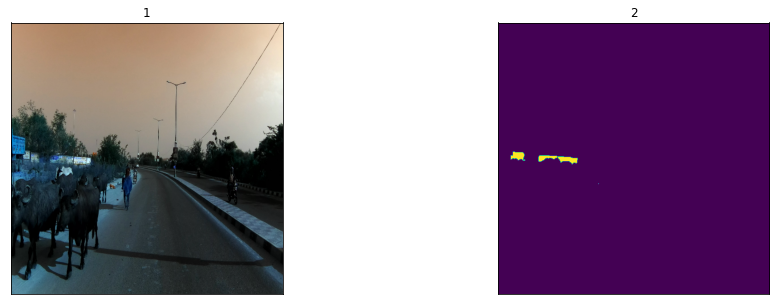

fence / guard rail


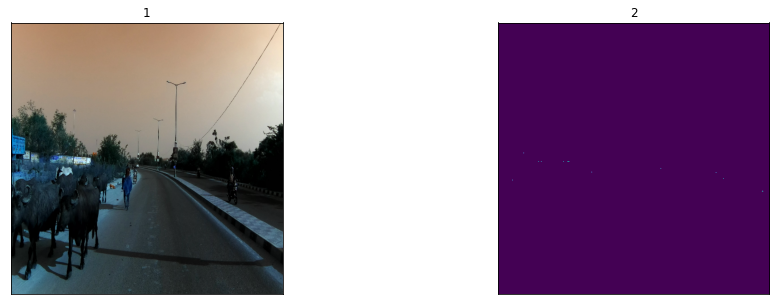

billboard / traffic sign / traffic light


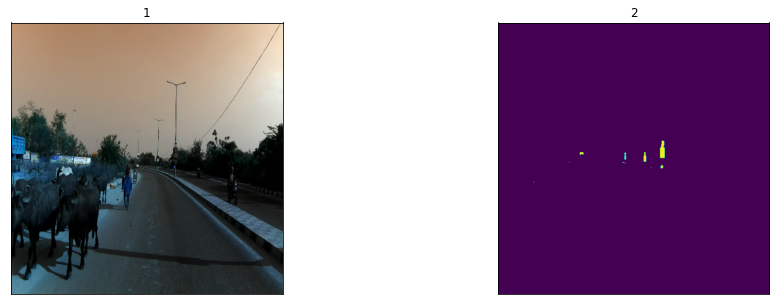

pole / polegroup / obs-str-bar-fallback


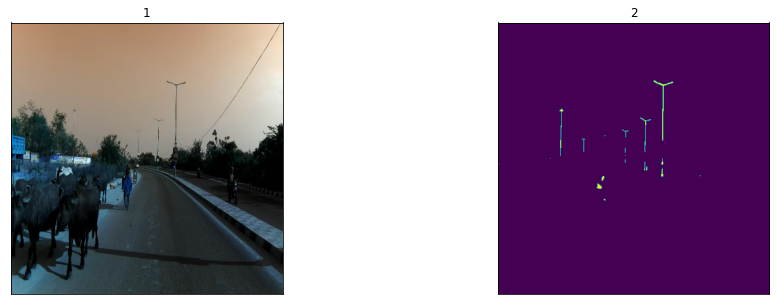

vegetation


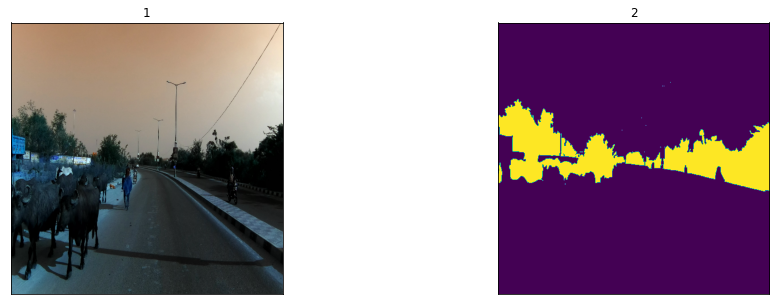

sky / fallback background


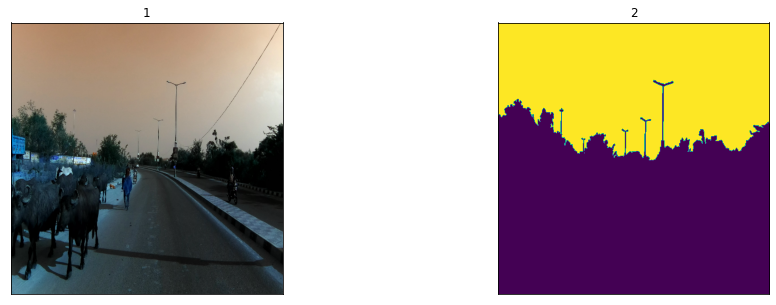

unlabeled / out of roi


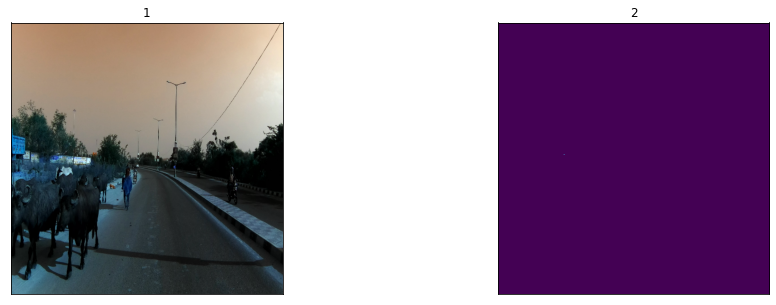

ego vehicle


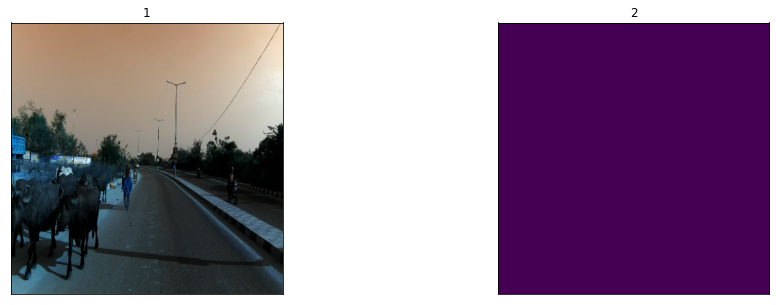

ground


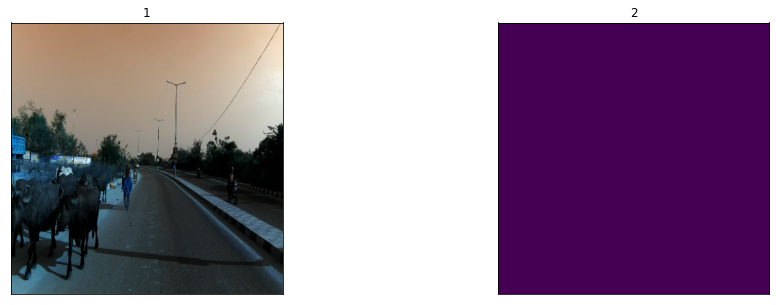

rectification border


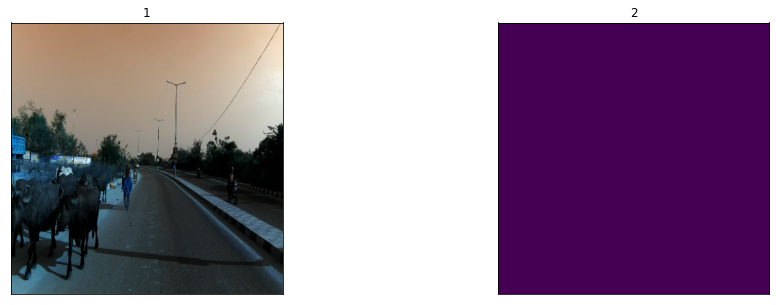

train


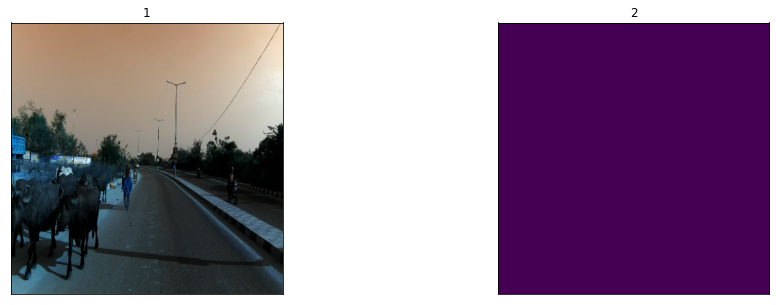

building / bridge / tunnel


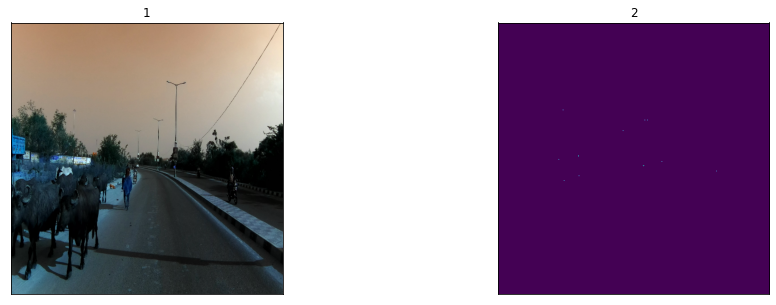

In [ ]:
idx = 3
for i in range(len(CLASSES)):
  print(list(new_label_clr.keys())[i])
  visualize({'1': train_dataset[idx][0], '2': train_dataset[idx][1][:,:,i]})
  plt.show()

In [ ]:

BATCH_SIZE = 4
train_dataloader = Dataloder(train_dataset, batch_size= BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size= BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, 21)



(4, 512, 512, 3)
(4, 512, 512, 21)


In [ ]:
# https://datascience.stackexchange.com/a/45166/75326
from keras import backend as K

def recall_k(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (actual_positives + K.epsilon())
    return recall

def precision_k(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_keras(y_true, y_pred):
    precision = precision_k(y_true, y_pred)
    recall = recall_k(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
optim = tf.keras.optimizers.Adam()

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, focal_loss, metrics=[sm.metrics.IOUScore(threshold = 0.5), f1_keras])

In [ ]:
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs= 20, \
                              validation_data=test_dataloader,)

Epoch 1/20
902/902 [==============================] - 699s 775ms/step - loss: 0.7827 - iou_score: 0.4034 - f1_keras: 0.7554 - val_loss: 0.6763 - val_iou_score: 0.4485 - val_f1_keras: 0.7792
Epoch 2/20
902/902 [==============================] - 676s 750ms/step - loss: 0.6785 - iou_score: 0.4825 - f1_keras: 0.8013 - val_loss: 0.6451 - val_iou_score: 0.5025 - val_f1_keras: 0.8176
Epoch 3/20
902/902 [==============================] - 684s 758ms/step - loss: 0.6389 - iou_score: 0.5146 - f1_keras: 0.8212 - val_loss: 0.7314 - val_iou_score: 0.4195 - val_f1_keras: 0.7171
Epoch 4/20
902/902 [==============================] - 683s 758ms/step - loss: 0.6140 - iou_score: 0.5353 - f1_keras: 0.8331 - val_loss: 0.6095 - val_iou_score: 0.4996 - val_f1_keras: 0.8113
Epoch 5/20
902/902 [==============================] - 684s 759ms/step - loss: 0.5967 - iou_score: 0.5502 - f1_keras: 0.8420 - val_loss: 0.6138 - val_iou_score: 0.5073 - val_f1_keras: 0.7912
Epoch 6/20
902/902 [==============================

In [ ]:

model.save('/content/drive/My Drive/model.h5', include_optimizer= False)

model1 = tf.keras.models.load_model('/content/drive/My Drive/model.h5')

optim = tf.keras.optimizers.Adam()

model1.compile(optim, focal_loss, metrics=[sm.metrics.IOUScore(threshold = 0.5), f1_keras])

history1 = model1.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs= 10, \
                              validation_data=test_dataloader,)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
902/902 [==============================] - 472s 524ms/step - loss: 0.3076 - iou_score: 0.6498 - f1_keras: 0.8956 - val_loss: 0.3582 - val_iou_score: 0.5949 - val_f1_keras: 0.8760
Epoch 2/10
902/902 [==============================] - 471s 522ms/step - loss: 0.2884 - iou_score: 0.6595 - f1_keras: 0.9007 - val_loss: 0.3594 - val_iou_score: 0.5960 - val_f1_keras: 0.8758
Epoch 3/10
902/902 [==============================] - 471s 522ms/step - loss: 0.2857 - iou_score: 0.6621 - f1_keras: 0.9019 - val_loss: 0.3547 - val_iou_score: 0.5987 - val_f1_keras: 0.8793
Epoch 4/10
902/902 [==============================] - 472s 523ms/step - loss: 0.2875 - iou_score: 0.6599 - f1_keras: 0.9013 - val_loss: 0.3492 - val_iou_score: 0.6030 - val_f1_keras: 0.8757
Epoch 5/10
902/902 [==============================] - 471s 522ms/step - loss: 0.2778 - iou_score: 0.6698 - f1_keras: 0.9063 - val_loss: 0.3495 - val_iou_score: 0.60

In [ ]:

model1.save('/content/drive/My Drive/model1.h5', include_optimizer= False)


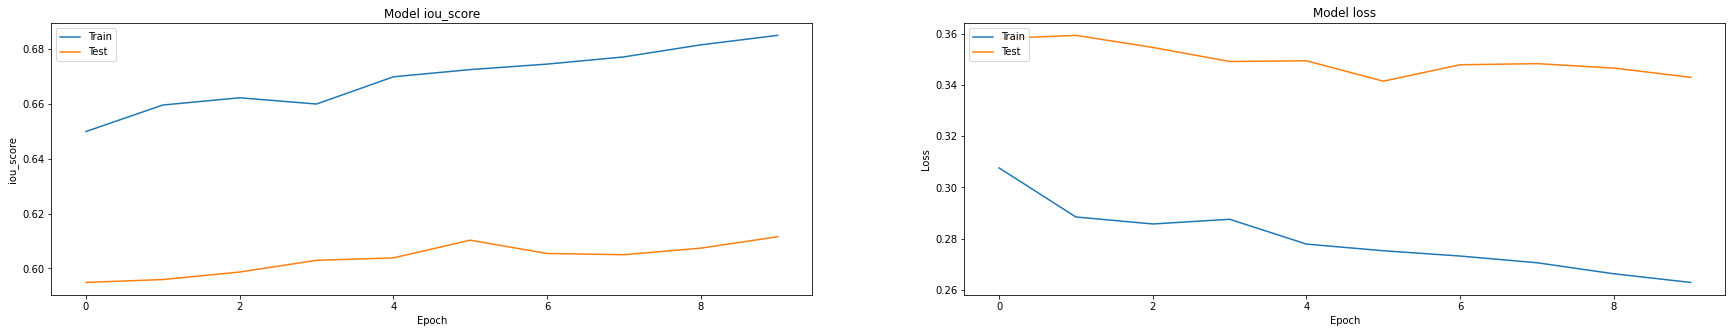

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history1.history['iou_score'])
plt.plot(history1.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model2 = tf.keras.models.load_model('/content/drive/My Drive/model1.h5')


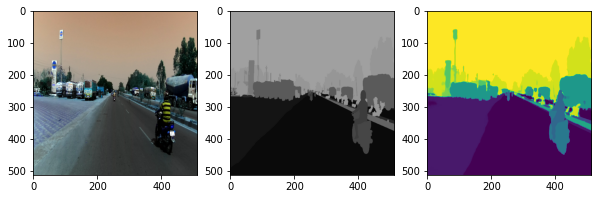

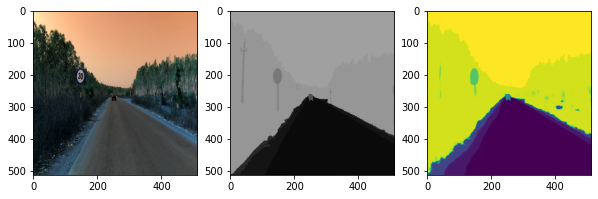

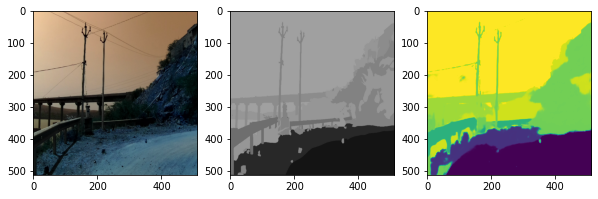

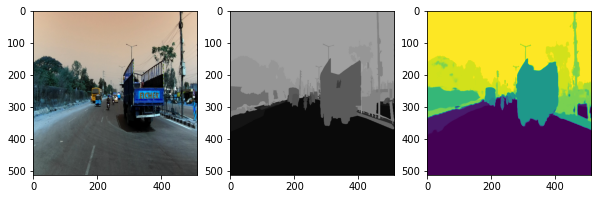

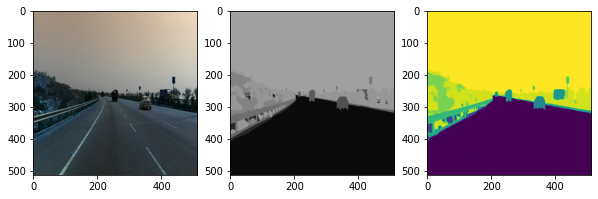

In [ ]:
# https://www.geeksforgeeks.org/iterating-over-rows-and-columns-in-pandas-dataframe/

img = X_test['image'][40:45]
mas = X_test['mask'][40:45]

for i, j in zip(img, mas):
    #original image
    image = cv2.imread(i, )
    image = cv2.resize(image, (512,512), ) 
    
    #predicted segmentation map
    predicted  = model2.predict(image[np.newaxis,:,:,:])
    predicted.shape
    
    #original segmentation map
    image_mask = cv2.imread(j)
    image_mask = cv2.resize(image_mask, (512,512))

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)

    z = np.zeros(shape = (512, 512), dtype = 'float32')
    for i in range(len(new_label_clr.values())):
       z += (predicted[0][:, :, i] * list(new_label_clr.values())[i])

    plt.imshow(z)
    plt.show()

**Observations**

* The dataset we have used has around 4008 images of HD resolution (1080 * 1980)
which are the pictures taken on various kinds of places mostly Traffic on roads in and around Hyderabad and Bengaluru.
* We have the coordinates and through which we have created polygons wherein these polygons are drawn onto a RGB image canvas but in 0 axis and hence we get a channels of 40, as we have 40 different classes.
* After the polygons are drawn we get y labelled images which are masked images of original and we use these in training to predict.
* As the classes are 40 and we need to color code them between 0-255 and we squeeze these classes further to 21 so that results during prediction shall be better.
* We havent normalized the images and also we havent used any image augumentation techniques too as the predictions are not good but we have resized the images t0 (512, 512) and we can  resize in multiples of 32 also as the U-NET accepts these image shapes only.
* We have used U-NET architechture as the shape of input image is same as shape of the output image.
* In U-NET we have used "resnet-34" as base model, as this gives us good results among other base models such as "resnet-50" or "VGG-16".
* We have used dice loss as loss and Adam as optimizer with default learning rates as the results are pretty good.
* This dice loss is a cce loss which is categorical cross entropy loss as this is multiclass classification.
* We train the model with two metrics such as F1 score and as well as IOU score, which is intersection over union also called as jaccared similarity.
* We ran for 30 epochs in all and the model was saved.
* The predictions are better as the loss is around 0.26 and val iou score is around 61.5 and train iou score is around 68.5.
* The model seems slightly overfit, but nonetheless the results are good as can viszualize.